# Parameters and imports

In [28]:
# random_seed = 20211216
random_seed = 20211218

# Use the "mini" training set with 9 images.
# fcd_ts_dir = '/content/drive/My Drive/PredatorEye/mini_training_set/'
# Use the "real" training set with 2008 images
fcd_ts_dir = '/content/drive/My Drive/PredatorEye/fcd_training_set/'

model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

# max_input_images = 100
max_input_images = 'all'

# For each image read from dataset "amplify" the set by up to 7 additional
# variations of the image via rotations and mirroring.
# When I tried using 8 I would run out of memory when the training began.
# amplification = 1
# amplification = 6
amplification = 8

# Maybe read from image file?
# Maybe assert all images are square and this size?
fcd_image_size = 1024

# Disk diameter, relative to full sized megapixel image.
fcd_disk_size = 201

# For scaling down the input image size.
# input_scale = 1
input_scale = 0.125
# input_scale = 0.25
# input_scale = 0.5
if (input_scale != 1):
    fcd_image_size = int(fcd_image_size * input_scale)
    # does this really want to be an int?
    fcd_disk_size = int(fcd_disk_size * input_scale)

fcd_epochs = 100
# fcd_epochs = 40

# On 20211218 increased from 32 to 128 which seemed to help stability.
fcd_batch_size = 128

In [29]:
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)





import gc
import PIL
import time
import pytz
import random
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from tqdm.auto import tqdm
from matplotlib import image
import matplotlib.pyplot as plt

# from DLAVA, includes unused symbols, maybe prune later
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import Loss

## maybe just write these inline in the code below?
from numpy import asarray 
from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

# 20211218
from sklearn.model_selection import train_test_split

from datetime import datetime


TensorFlow version: 2.7.0


In [30]:
# Check for Colab Pro resources
def check_colab_resources():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    if ram_gb < 20:
        print('Not using a high-RAM runtime.')
    else:
        print('Using a high-RAM runtime.')
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

check_colab_resources()

Mon Dec 20 22:16:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    44W / 250W |   8769MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Utilities

In [31]:
# Prints "expression = <value>"
def debug_print(expression):
    print(expression, '=', eval(expression))

# Reset random sequence seeds in Python's "random", Numpy, and TensorFlow.
def reset_random_seeds():
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

# Parse FCD filename to a list of two ints: (x, y) pixel coordinates.
def fcd_filename_to_xy_ints(filename):
    without_extension = filename.split('.')[0]
    two_numeric_strings = without_extension.split('_')[1:3]
    return list(map(int, two_numeric_strings))

# Get image label from image file names ([x, y] as floats on [0,1])
def fcd_normalized_xy(filename, pixels):
    pixel_coordinates = fcd_filename_to_xy_ints(filename)
    return pixel_coordinates / (np.array(pixels.shape)[1:2] / input_scale)

# Draw a training image on the log. First arg is either a 24 bit RGB pixel
# representation as read from file, or the rescaled 3xfloat used internally.
# Optionally draw crosshairs to show center of disk.
def draw_image(rgb_pixel_tensor, center=(0,0)):
    i24bit = []

    # 20211218
    # if (rgb_pixel_tensor.dtype == np.double):
    if (rgb_pixel_tensor.dtype == np.float32):

        unscaled_pixels = np.interp(rgb_pixel_tensor, [0, 1], [0, 255])
        i24bit = Image.fromarray(unscaled_pixels.astype('uint8'), mode='RGB')
    else:
        i24bit = Image.fromarray(rgb_pixel_tensor)
    plt.imshow(i24bit)
    if (center != (0,0)):
        draw_crosshairs(center)
    plt.show()

# Draw crosshairs to indicate disk position (label or estimate).
def draw_crosshairs(center):
    m = fcd_image_size - 1       # max image coordinate
    s = fcd_disk_size * 1.2 / 2  # gap size (radius)
    h = center[0] * m            # center x in pixels
    v = center[1] * m            # center y in pixels
    plt.hlines(v, 0, max(0, h - s), color="black")
    plt.hlines(v, min(m, h + s), m, color="black")
    plt.vlines(h, 0, max(0, v - s), color="white")
    plt.vlines(h, min(m, v + s), m, color="white")

# Draw line in plot between arbitrary points in plot.
# eg: draw_line((100, 100), (924, 924), color="yellow")
def draw_line(p1, p2, color="white"):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color)

# debug_print('fcd_filename_to_xy_ints("foobar_123_456")')
# debug_print('fcd_normalized_xy("foobar_123_456", np.zeros((1024,1024,3)))')
# debug_print('[123/(1024/input_scale), 456/(1024/input_scale)]')

def timestamp_string():
    # Just assert that we want to use Pacific time, for the benefit of cwr.
    # The Colab server seems to think local time is UTC.
    return datetime.now(pytz.timezone('US/Pacific')).strftime('%Y%m%d_%H%M')

# Data reader

In [32]:
# # Loads FCD training data image files from "directory_pathname". Returns an
# # array of images and an array of labels (each an XY pair, the relative position
# # of the disk center). Optional "image_count" can limit the number of images
# # read, by taking a random sample of availble image files, defaults to "all".

# def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
#     directory_contents = listdir(directory_pathname)
#     if (image_count == 'all'): image_count = len(directory_contents)
#     assert image_count <= len(directory_contents), "Too few images in directory"
#     directory_contents = random.sample(directory_contents, image_count)
#     image_count *= amplification # for rot/mir
#     print('Reading', max_input_images, 'images from ' + fcd_ts_dir)
#     print('With an amplification factor of', amplification,
#           'for a total of', image_count, 'images in dataset.')

#     # Pre-allocate a tensor for all image data and one for all labels.
#     local_images = np.zeros([image_count, fcd_image_size, fcd_image_size, 3])
#     local_labels = np.zeros([image_count, 2])
#     image_index = 0
#     for filename in tqdm(directory_contents):
#         image_pathname = join(directory_pathname, filename)
#         # Numpy pixel array of image object.
#         image = Image.open(image_pathname)
#         new_size = (fcd_image_size, fcd_image_size)
#         pixels = asarray(image.resize(new_size, PIL.Image.LANCZOS))
#         # Convert input image data to floating-point.
#         float_pixels = keras_backend.cast_to_floatx(pixels)
#         # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
#         scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
#         # Read disk center position from file name.
#         center_position = fcd_normalized_xy(filename, pixels)
#         def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
#         def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])
#         variations = 8  # 4 from rotations times two from mirroring
#         assert ((amplification > 0) and (amplification <= variations))
#         keepers = random.sample(range(1, variations), amplification - 1)
#         keepers.append(0)
#         for i in range(variations):
#             if (keepers.count(i) > 0):
#                 # Copy pixel data into slice "image_index" of "local_images"
#                 local_images[image_index, :, :, :] = scaled_pixels
#                 # Copy disk center XY position into slice of "local_labels".
#                 local_labels[image_index, :] = center_position
#                 image_index += 1
#                 draw_frequency = 50 * amplification
#                 # 20211216 is this using up too much memory (for amp=8)?
#                 # if ((image_index % draw_frequency) == draw_frequency - 1):
#                 #     draw_image(scaled_pixels, center_position)
#                 #     print(image_index + 1, "of", image_count, "images...")
#             if (i < 7):
#                 if (i == 3):
#                     scaled_pixels = np.flip(scaled_pixels, axis=1)
#                     center_position = center_flip(center_position)
#                 else:
#                     scaled_pixels = np.rot90(scaled_pixels, k=1, axes=(0, 1))
#                     center_position = center_rot90(center_position)
#     return local_images, local_labels

# Loads FCD training data image files from "directory_pathname". Returns an
# array of images and an array of labels (each an XY pair, the relative position
# of the disk center). Optional "image_count" can limit the number of images
# read, by taking a random sample of availble image files, defaults to "all".

def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
    directory_contents = listdir(directory_pathname)
    if (image_count == 'all'): image_count = len(directory_contents)
    assert image_count <= len(directory_contents), "Too few images in directory"
    directory_contents = random.sample(directory_contents, image_count)
    image_count *= amplification # for rot/mir
    print('Reading', max_input_images, 'images from ' + fcd_ts_dir)
    print('With an amplification factor of', amplification,
          'for a total of', image_count, 'images in dataset.')

    # 20211218

    # # Pre-allocate a tensor for all image data and one for all labels.
    # local_images = np.zeros([image_count, fcd_image_size, fcd_image_size, 3])
    # local_labels = np.zeros([image_count, 2])

    # Pre-allocate a tensor for all image data and one for all labels.
    local_images = []
    local_labels = []

    image_index = 0
    for filename in tqdm(directory_contents):
        image_pathname = join(directory_pathname, filename)
        # Numpy pixel array of image object.
        image = Image.open(image_pathname)
        new_size = (fcd_image_size, fcd_image_size)

        # 20211218
        # pixels = asarray(image.resize(new_size, PIL.Image.LANCZOS))
        pixels = asarray(image.resize(new_size, PIL.Image.LANCZOS),
                         dtype=np.float32)
        
        # Convert input image data to floating-point.
        float_pixels = keras_backend.cast_to_floatx(pixels)
        # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
        scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
        # Read disk center position from file name.
        center_position = fcd_normalized_xy(filename, pixels)
        def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
        def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])
        variations = 8  # 4 from rotations times two from mirroring
        assert ((amplification > 0) and (amplification <= variations))
        keepers = random.sample(range(1, variations), amplification - 1)
        keepers.append(0)
        for i in range(variations):
            if (keepers.count(i) > 0):

                # 20211218

                # # Copy pixel data into slice "image_index" of "local_images"
                # local_images[image_index, :, :, :] = scaled_pixels
                # # Copy disk center XY position into slice of "local_labels".
                # local_labels[image_index, :] = center_position

                # Append pixel data to "local_images"
                local_images.append(scaled_pixels)
                # Append disk center XY position to "local_labels".
                local_labels.append(center_position)

                image_index += 1
                draw_frequency = 50 * amplification
                # 20211216 is this using up too much memory (for amp=8)?
                # if ((image_index % draw_frequency) == draw_frequency - 1):
                #     draw_image(scaled_pixels, center_position)
                #     print(image_index + 1, "of", image_count, "images...")
            if (i < 7):
                if (i == 3):
                    scaled_pixels = np.flip(scaled_pixels, axis=1)
                    center_position = center_flip(center_position)
                else:
                    scaled_pixels = np.rot90(scaled_pixels, k=1, axes=(0, 1))
                    center_position = center_rot90(center_position)
    return local_images, local_labels

# Distance-based loss

In [33]:
# class FCDPositionLoss(Loss):
#     # def __init__(self, regularization_factor=0.1, name="custom_mse"):
#     def __init__(self,
#                  # diameter = fcd_image_size / fcd_disk_size,
#                  diameter = float(fcd_disk_size) / float(fcd_image_size),
#                  name = "custom_mse"):
#         super().__init__(name="fcd_position_loss")
#         self.diameter = diameter

#     def call(self, y_true, y_pred):
#         # mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
#         # reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
#         # return mse + reg * self.regularization_factor
#         # return fcd_position_loss_helper(y_true, y_pred)
#         return corresponding_distances(y_true, y_pred)

# class FCDDiskShapedLoss(Loss):
#     # def __init__(self, regularization_factor=0.1, name="custom_mse"):
#     def __init__(self,
#                  # diameter = fcd_image_size / fcd_disk_size,
#                 #  diameter = float(fcd_disk_size) / float(fcd_image_size),
#                  radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2,
#                  name = "custom_mse"):
#         super().__init__(name="fcd_disk_shaped_loss")
#         self.radius = radius

#     def call(self, y_true, y_pred):
#         # d = corresponding_distances(y_true, y_pred)
#         # print("d", d)
#         # scaled = (d / self.radius)
#         # print("scaled", scaled)
#         # exponentiated = scaled ** 4
#         # print("exponentiated", exponentiated)
#         # return exponentiated
#         # return fcd_disk_shaped_loss_helper(self.radius, y_true, y_pred)
#         return fcd_disk_shaped_loss_helper(y_true, y_pred, self.radius)

# Calculates RELATIVE disk radius on the fly -- rewrite later.
def fcd_disk_radius():
    return (float(fcd_disk_size) / float(fcd_image_size)) / 2

def fcd_disk_shaped_loss_helper(y_true, y_pred):
    radius = fcd_disk_radius()
    d = corresponding_distances(y_true, y_pred)
    # print("d", d)
    scaled = d / radius
    # print("scaled", scaled)
    exponentiated = scaled ** 4
    # print("exponentiated", exponentiated)
    return exponentiated

# Given two tensors of 2d point coordinates, return a tensor of the Cartesian
# distance between corresponding points in the input tensors.
def corresponding_distances(y_true, y_pred):
    true_pos_x, true_pos_y = tf.split(y_true, num_or_size_splits=2, axis=1)
    pred_pos_x, pred_pos_y = tf.split(y_pred, num_or_size_splits=2, axis=1)
    dx = true_pos_x - pred_pos_x
    dy = true_pos_y - pred_pos_y
    distances = tf.sqrt(tf.square(dx) + tf.square(dy))
    return distances

In [34]:
# Prototype metric to measure the fraction of predictions that are inside disks.
# For each pair of 2d points of input, output tensor is 1 for IN and 0 for OUT.
# def fcd_prediction_inside_disk(y_true, y_pred):

# (make name shorter so it is easier to read fit() log.)
def in_disk(y_true, y_pred):
    distances = corresponding_distances(y_true, y_pred)
    # relative_disk_radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2

    # From https://stackoverflow.com/a/42450565/1991373
    # Boolean tensor marking where distances are less than relative_disk_radius.
    # insides = tf.less(distances, relative_disk_radius)
    insides = tf.less(distances, fcd_disk_radius())
    map_to_zero_or_one = tf.cast(insides, tf.int32)
    return map_to_zero_or_one


example_true_positions = tf.convert_to_tensor([[1.0, 2.0],
                                               [3.0, 4.0],
                                               [5.0, 6.0],
                                               [7.0, 8.0]])
example_pred_positions = tf.convert_to_tensor([[1.1, 2.0],
                                               [3.0, 4.2],
                                            #    [5.0, 6.1],
                                               [5.0, 6.0],
                                               [7.3, 8.0]])

in_disk(example_true_positions, example_pred_positions)
fcd_disk_shaped_loss_helper(example_true_positions, example_pred_positions)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[ 1.0995128],
       [17.592115 ],
       [ 0.       ],
       [89.06067  ]], dtype=float32)>

# Keras model utilities

In [35]:
# # Construct a Keras model with CNN layers at the front, striding down in
# # resolution, then dense layers funneling down to just two output neurons
# # representing the predicted image position center of the conspicuous disk.
# # (First version cribbed from DLAVA chapter B3, Listing B3-41)

# # def make_striding_cnn_model():
# def make_fcd_cnn_model():
#     cnn_act = 'relu'
#     dense_act = 'relu'
#     output_act = 'linear'
#     cnn_dropout = 0.2
#     dense_dropout = 0.5  # ala Hinton (2012)
#     model = Sequential()
#     # Two units of:
#     #     2 CNN layers with 3x3 32 filters, second one striding down by half
#     #     followed by dropout
#     #
#     # 20211215 maybe use 5x5 for first of each layer? more drop out?
#     # 20211217 change 3x3/3x3 to 5x5/3x3, now try 7x7/5x5
#     #          temporarily turn off dropout
#     #          temporarily switch back to MSE
#     #          go back to 5x5/3x3
#     #          add back all dropout
#     #          add dropout to next 2 dense layers (was 512, now add 128 and 32)
#     #          nope, remove that.
#     #          try doubling the number of filters in the CNN layer 32 to 64.
#     #          nope, remove that.
#     #          In the 2 CNN groups, add a second 3x3 CNN/dropout between other 2

#     # model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same',
#     model.add(Conv2D(32, (5, 5), activation=cnn_act, padding='same',
#     # model.add(Conv2D(64, (5, 5), activation=cnn_act, padding='same',
#     # model.add(Conv2D(32, (7, 7), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3),
#                      input_shape=(fcd_image_size, fcd_image_size, 3)))
#     # model.add(Dropout(cnn_dropout)) # added 20211215 9:30 am ###################
#     model.add(Dropout(cnn_dropout))

#     # 20211217 4:45pm add a second 3x3 CNN/dropout between other 2:
#     model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))

#     model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same',
#     # model.add(Conv2D(64, (3, 3), activation=cnn_act, padding='same',
#     # model.add(Conv2D(32, (5, 5), activation=cnn_act, padding='same',
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout)) # removed 20211215 9:55 am ###############
#     model.add(Dropout(cnn_dropout))

#     # model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
#     model.add(Conv2D(32, (5, 5), activation=cnn_act, padding='same', 
#     # model.add(Conv2D(64, (5, 5), activation=cnn_act, padding='same', 
#     # model.add(Conv2D(32, (7, 7), activation=cnn_act, padding='same', 
#                      kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout)) # added 20211215 9:30 am ###################
#     model.add(Dropout(cnn_dropout))

#     # 20211217 4:45pm add a second 3x3 CNN/dropout between other 2:
#     model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))

#     model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
#     # model.add(Conv2D(64, (3, 3), activation=cnn_act, padding='same', 
#     # model.add(Conv2D(32, (5, 5), activation=cnn_act, padding='same', 
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout)) # removed 20211215 9:55 am ###############
#     model.add(Dropout(cnn_dropout))

#     # 20211215 double largest size, decrease by factor of 4, etc.
#     # try again at 10:50am, with dropout of 0.3 instead of 0.5

#     # Then flatten and use a large-ish dense layer with heavy dropout.
#     model.add(Flatten())
#     model.add(Dense(512, activation=dense_act))
    
#     # model.add(Dropout(dense_dropout))
#     # model.add(Dropout(0.3))
#     model.add(Dropout(dense_dropout))

#     # Then funnel down to two output neurons for (x, y) of predicted center.
#     model.add(Dense(128, activation=dense_act))
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(32, activation=dense_act))
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(8, activation=dense_act))
#     model.add(Dense(2, activation=output_act))

#     # Compile with disk-shaped loss, tracking accuracy and fraction-inside-disk.
#     # model.compile(loss=fcd_disk_shaped_loss_helper,
#     model.compile(loss='mse',
#                   optimizer='adam', metrics=["accuracy", in_disk])
#     return model

# # 20211219 experiments:
# #     First make cnn_filters a named parameter, then change from 32 to 48
# #     Then reduce it to 16, while adding yet another CNN layer in each "unit"
# #     Then set cnn_filters to 64 and reduce each unit to the (original) 2 CNNs.


# # Construct a Keras model with CNN layers at the front, striding down in
# # resolution, then dense layers funneling down to just two output neurons
# # representing the predicted image position center of the conspicuous disk.
# # (First version cribbed from DLAVA chapter B3, Listing B3-41)

# def make_fcd_cnn_model():
#     cnn_act = 'relu'
#     dense_act = 'relu'
#     output_act = 'linear'
#     cnn_dropout = 0.2
#     dense_dropout = 0.5  # ala Hinton (2012)
#     # cnn_filters = 32
#     # cnn_filters = 48
#     # cnn_filters = 16
#     cnn_filters = 64

#     model = Sequential()
#     # Two units of:
#     #     ...rewrite...
#     model.add(Conv2D(cnn_filters, (5, 5), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3),
#                      input_shape=(fcd_image_size, fcd_image_size, 3)))
#     model.add(Dropout(cnn_dropout))
#     # ###
#     # # 20211219 11:50 duplicate
#     # model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#     #                  kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout))
#     # model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#     #                  kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout))
#     # ###
#     model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))

#     model.add(Conv2D(cnn_filters, (5, 5), activation=cnn_act, padding='same', 
#                      kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))
#     # ###
#     # # 20211219 11:50 duplicate
#     # model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#     #                  kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout))
#     # model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#     #                  kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout))
#     # ###
#     model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same', 
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))

#     # Then flatten and use a large-ish dense layer with heavy dropout.
#     model.add(Flatten())
#     model.add(Dense(512, activation=dense_act))
#     model.add(Dropout(dense_dropout))

#     # Then funnel down to two output neurons for (x, y) of predicted center.
#     model.add(Dense(128, activation=dense_act))
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(32, activation=dense_act))
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(8, activation=dense_act))
#     model.add(Dense(2, activation=output_act))

#     # Compile with mse loss, tracking accuracy and fraction-inside-disk.
#     model.compile(loss='mse', optimizer='adam', metrics=["accuracy", in_disk])
#     return model

# 20211219 experiments:
#     First make cnn_filters a named parameter, then change from 32 to 48
#     Then reduce it to 16, while adding yet another CNN layer in each "unit"
#     Then set cnn_filters to 64 and reduce each unit to the (original) 2 CNNs.

# 20211220:
#     back to 48 filters and three CNNs per unit.

# # Construct a Keras model with CNN layers at the front, striding down in
# # resolution, then dense layers funneling down to just two output neurons
# # representing the predicted image position center of the conspicuous disk.
# # (First version cribbed from DLAVA chapter B3, Listing B3-41)

# def make_fcd_cnn_model():
#     cnn_act = 'relu'
#     dense_act = 'relu'
#     output_act = 'linear'
#     cnn_dropout = 0.2
#     dense_dropout = 0.5  # ala Hinton (2012)
#     # cnn_filters = 32
#     cnn_filters = 48
#     # cnn_filters = 16
#     # cnn_filters = 64

#     model = Sequential()
#     # Two units of:
#     #     ...rewrite...
#     model.add(Conv2D(cnn_filters, (5, 5), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3),
#                      input_shape=(fcd_image_size, fcd_image_size, 3)))
#     model.add(Dropout(cnn_dropout))
#     # ###
#     # # 20211219 11:50 duplicate
#     model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))
#     # model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#     #                  kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout))
#     # ###
#     model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))

#     model.add(Conv2D(cnn_filters, (5, 5), activation=cnn_act, padding='same', 
#                      kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))
#     # ###
#     # # 20211219 11:50 duplicate
#     model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#                      kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))
#     # model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
#     #                  kernel_constraint=MaxNorm(3)))
#     # model.add(Dropout(cnn_dropout))
#     # ###
#     model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same', 
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))

#     # Then flatten and use a large-ish dense layer with heavy dropout.
#     model.add(Flatten())
#     model.add(Dense(512, activation=dense_act))
#     model.add(Dropout(dense_dropout))

#     # Then funnel down to two output neurons for (x, y) of predicted center.
#     model.add(Dense(128, activation=dense_act))
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(32, activation=dense_act))
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(8, activation=dense_act))
#     model.add(Dense(2, activation=output_act))

#     # Compile with mse loss, tracking accuracy and fraction-inside-disk.
#     model.compile(loss='mse', optimizer='adam', metrics=["accuracy", in_disk])
#     return model

# Construct a Keras model with CNN layers at the front, striding down in
# resolution, then dense layers funneling down to just two output neurons
# representing the predicted image position center of the conspicuous disk.
# (First version cribbed from DLAVA chapter B3, Listing B3-41)

# 20211220:
#     back to 48 filters and three CNNs per unit.
#     increase cnn_dropout from 0.2 to 0.3, add dropout for Dense(128)

def make_fcd_cnn_model():
    cnn_act = 'relu'
    dense_act = 'relu'
    output_act = 'linear'
    cnn_dropout = 0.2
    dense_dropout = 0.5  # ala Hinton (2012)
    cnn_filters = 48

    model = Sequential()
    # Two units of:
    #     ...rewrite...
    model.add(Conv2D(cnn_filters, (5, 5), activation=cnn_act, padding='same',
                     kernel_constraint=MaxNorm(3),
                     input_shape=(fcd_image_size, fcd_image_size, 3)))
    model.add(Dropout(cnn_dropout))
    model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))
    model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))

    model.add(Conv2D(cnn_filters, (5, 5), activation=cnn_act, padding='same', 
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))
    model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same',
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))
    model.add(Conv2D(cnn_filters, (3, 3), activation=cnn_act, padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))

    # Then flatten and use a large-ish dense layer with heavy dropout.
    model.add(Flatten())
    model.add(Dense(512, activation=dense_act))
    model.add(Dropout(dense_dropout))

    # Then funnel down to two output neurons for (x, y) of predicted center.
    model.add(Dense(128, activation=dense_act))
    model.add(Dropout(dense_dropout))
    model.add(Dense(32, activation=dense_act))
    # model.add(Dropout(dense_dropout))
    model.add(Dense(8, activation=dense_act))
    model.add(Dense(2, activation=output_act))

    # Compile with mse loss, tracking accuracy and fraction-inside-disk.
    model.compile(loss='mse', optimizer='adam', metrics=["accuracy", in_disk])
    return model

In [36]:
# Utility to fit and plot a run, again cribbed from DLAVA chapter B3.
def run_model(model_maker, plot_title):
    model = model_maker()

    # print("In run_model():")
    # debug_print('X_train.shape')
    # debug_print("y_train.shape")
    # 20211218
    # history = model.fit(X_train, y_train, validation_split=0.2,
    #                     epochs=fcd_epochs, batch_size=fcd_batch_size)
    
    # (X_train, X_test, y_train, y_test)

    history = model.fit(X_train,
                        y_train,

                        # validation_split=0.2,
                        validation_data = (X_test, y_test),
                        
                        epochs=fcd_epochs,
                        batch_size=fcd_batch_size)


    print()
    plot_accuracy_and_loss(history, plot_title)
    return model, history

# A little utility to draw plots of accuracy and loss.
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))
    # plt.figure(figsize=(10,3))
    plt.figure(figsize=(15,3))

    # plt.subplot(1, 2, 1)
    plt.subplot(1, 3, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+': Accuracy')

    plt.subplot(1, 3, 2)
    # plt.plot(xs, history.history['fcd_prediction_inside_disk'], label='train')
    # plt.plot(xs, history.history['val_fcd_prediction_inside_disk'], label='validation')
    plt.plot(xs, history.history['in_disk'], label='train')
    plt.plot(xs, history.history['val_in_disk'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('fraction inside disk')
    plt.title(plot_title+': fraction inside disk')

    # plt.subplot(1, 2, 2)
    plt.subplot(1, 3, 3)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+': Loss')

    plt.show()

# Read training data

In [37]:
# Read FCD training data from a given directory.
reset_random_seeds()
start_time = time.time()
# (X_train, y_train) = ([], [])  # To release memory when rerunning in notebook.
# To release memory when rerunning in notebook.
(X_train, X_test, y_train, y_test) = ([], [], [], [])  
gc.collect()
(X_train, y_train) = read_fcd_data_from_directory(fcd_ts_dir, max_input_images)
# print('Total of', X_train.shape[0], 'labeled images.')
print('Total of', len(X_train), 'labeled images.')

# 20211218
(X_train, X_test, y_train, y_test) = train_test_split(X_train, y_train,
                                                      test_size=0.2)
print('len(X_train) =', len(X_train))
print('len(y_train) =', len(y_train))
print('len(X_test) =', len(X_test))
print('len(y_test) =', len(y_test))

# Convert from python lists to np array.
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('Elapsed time:', int(time.time() - start_time), 'seconds.')

Reading all images from /content/drive/My Drive/PredatorEye/fcd_training_set/
With an amplification factor of 8 for a total of 40000 images in dataset.


  0%|          | 0/5000 [00:00<?, ?it/s]

Total of 40000 labeled images.
len(X_train) = 32000
len(y_train) = 32000
len(X_test) = 8000
len(y_test) = 8000
Elapsed time: 182 seconds.


# Build and train model

Epoch 1/100
250/250 [==============================] - 56s 220ms/step - loss: 0.3199 - accuracy: 0.4987 - in_disk: 0.0458 - val_loss: 0.0553 - val_accuracy: 0.5055 - val_in_disk: 0.0511
Epoch 2/100
250/250 [==============================] - 53s 211ms/step - loss: 0.0561 - accuracy: 0.4994 - in_disk: 0.0491 - val_loss: 0.0545 - val_accuracy: 0.5055 - val_in_disk: 0.0521
Epoch 3/100
250/250 [==============================] - 53s 212ms/step - loss: 0.0546 - accuracy: 0.4959 - in_disk: 0.0494 - val_loss: 0.0545 - val_accuracy: 0.4945 - val_in_disk: 0.0524
Epoch 4/100
250/250 [==============================] - 53s 211ms/step - loss: 0.0543 - accuracy: 0.5034 - in_disk: 0.0492 - val_loss: 0.0545 - val_accuracy: 0.4945 - val_in_disk: 0.0520
Epoch 5/100
250/250 [==============================] - 53s 211ms/step - loss: 0.0542 - accuracy: 0.4994 - in_disk: 0.0503 - val_loss: 0.0545 - val_accuracy: 0.4945 - val_in_disk: 0.0523
Epoch 6/100
250/250 [==============================] - 53s 211ms/step 

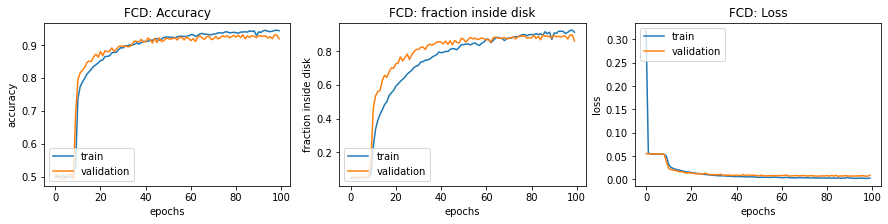

Elapsed time: 5284 seconds (88 minutes).


In [38]:
# Run a model.
reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

(model, history) = run_model(make_fcd_cnn_model, 'FCD')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# Analyze results

2530 : ( 0.68306196 , 0.7196581 )


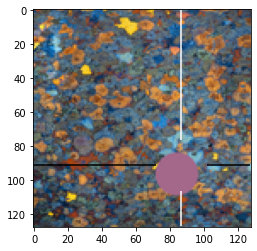

5592 : ( 0.28618187 , 0.7497888 )


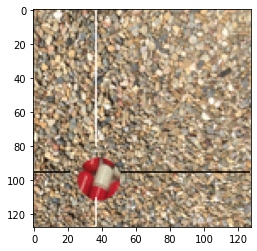

2460 : ( 0.52015615 , 0.1317505 )


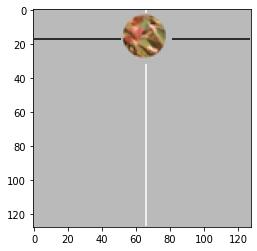

7393 : ( 0.5881802 , 0.6481503 )


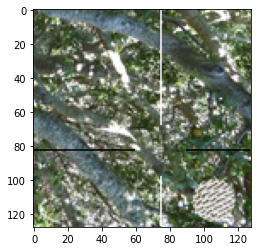

203 : ( 0.67732334 , 0.3767123 )


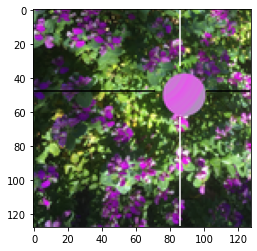

5870 : ( 0.6927004 , 0.6567679 )


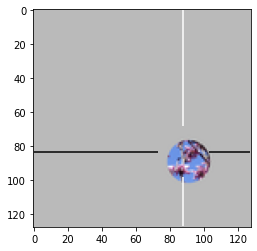

3431 : ( 0.5306289 , 0.8732925 )


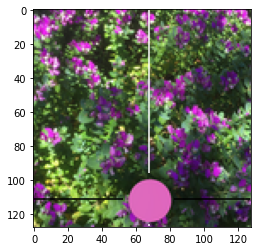

3485 : ( 0.41588837 , 0.8575773 )


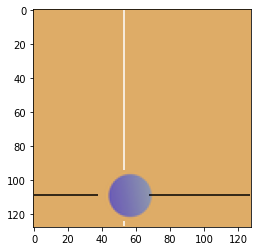

1381 : ( 0.29613063 , 0.6215837 )


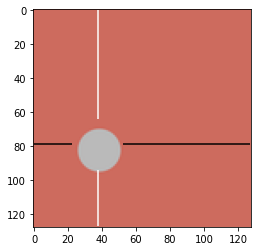

7644 : ( 0.13920116 , 0.32085896 )


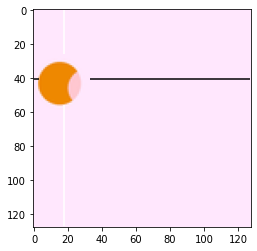

4895 : ( 0.4639366 , 0.62808144 )


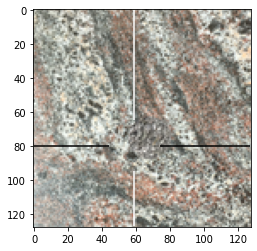

5370 : ( 0.4946419 , 0.60676986 )


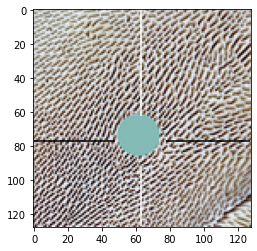

5265 : ( 0.3143371 , 0.37981138 )


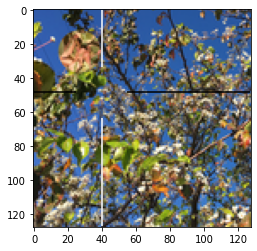

5068 : ( 0.1405099 , 0.72290623 )


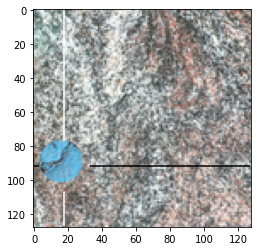

2104 : ( 0.4077543 , 0.7483645 )


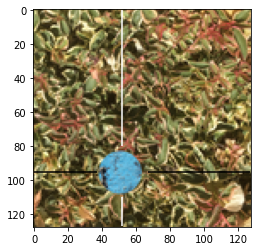

6002 : ( 0.5648884 , 0.25792825 )


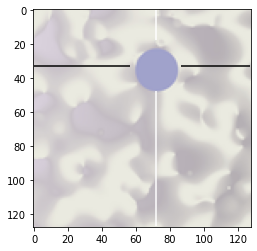

7389 : ( 0.27438605 , 0.5360657 )


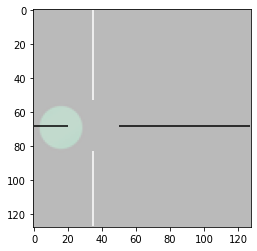

7308 : ( 0.8338549 , 0.79586333 )


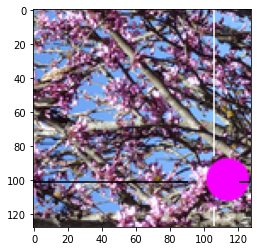

348 : ( 0.40287158 , 0.39585063 )


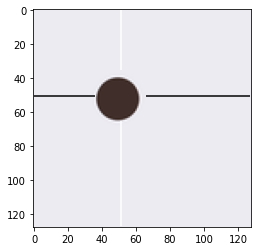

614 : ( 0.8433961 , 0.123206824 )


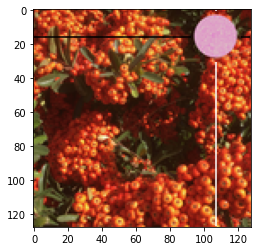

In [39]:
# Draw some results to understand performance
# TODO needs to discriminate between training and validation sets.
#      feature best/worse results of both cases?
# 20211210 refactor to not run predict on whole training set
def draw_results(count = 20):

    # 20211218 (should be a parameter to draw_results())
    # for i in random.sample(range(X_train.shape[0]), count) :
    for i in random.sample(range(X_test.shape[0]), count) :

        # 20211218 (should be a parameter to draw_results())
        # pixel_tensor = X_train[i, :, :, :]
        pixel_tensor = X_test[i, :, :, :]
        
        predict = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
        x = predict[0]
        y = predict[1]
        print(i, ": (", x, ",", y, ")")

        # 20211218
        # draw_image(X_train[i, :, :, :], [x, y])
        draw_image(pixel_tensor, [x, y])

reset_random_seeds()
draw_results()

# Save model

In [40]:
# Maybe this should be merged in with the "build and train model" section.
model.save(model_save_directory + fcd_model_timestamp)

INFO:tensorflow:Assets written to: /content/drive/My Drive/PredatorEye/saved_models/20211220_1419/assets
